### Preamble

In [1]:
import sympy as sym
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
from FwtModels import effective_aoa as eAoA

# Simplify the $\alpha_h$ Model

Previously I have generated a geometrically exact representation of the effective AoA of the hinged wingtip, the aim of this document is to turn this into a simplified model which can be more readily used in simulations

# Generate the geometrically exact model and produce numerical data for it

In [2]:
## a/c to wind transform
alpha,beta = sym.symbols(['alpha','beta'])
Lambda,theta = sym.symbols(['Lambda','theta'])

# Velocity vector in velocity frame is of the form [v 0 0]
u = sym.Symbol('u')
V = sym.Matrix([u,0,0])


Vh = eAoA.GeomExact(alpha,beta,Lambda,theta,V)

ExactModel = sym.lambdify((alpha,beta,Lambda,theta,u),Vh)

In [3]:
# Create test conditions
AoAs = np.linspace(0,10,5)
Thetas = np.linspace(-180,180,361)
Lambdas = np.linspace(0,25,6)
Betas = np.array([0])

dat = []

for i in AoAs:
    aoa_r = np.deg2rad(i)
    for j in Thetas:
        theta_r = np.deg2rad(j)
        for k in Lambdas:
            Lambda_r = np.deg2rad(k)
            for w in Betas:
                beta_r = np.deg2rad(w)
                dat.append([i,j,k,w])

TestConditions = pd.DataFrame(data = dat,columns=['Alpha','Theta','Lambda','Beta'])

In [4]:
# function to convert a function for v relationship into AoA info
def GetFwtAoAFromModel(TestConditions,func,ModelName,includeZeroLift=False):
    ModelData = TestConditions.copy()
    # get list of velocoty vectors
    alpha = np.deg2rad(ModelData['Alpha'])
    beta = np.deg2rad(ModelData['Beta'])
    Lambda = np.deg2rad(ModelData['Lambda'])
    theta = np.deg2rad(ModelData['Theta'])
    l_vs = func(alpha,beta,Lambda,theta,1).T
    #convert vectors to 2D array
    vs = []
    for i in l_vs:
        vs.append(i[0])
    vs = np.array(vs)
    # add velocity components to df
    ModelData = pd.concat([ModelData,pd.DataFrame(data=vs,columns=['v1','v2','v3'])],axis=1)
    
    # Add other info
    ModelData['Alpha_h'] = np.rad2deg((ModelData['v3']/ModelData['v1']).apply(np.arctan))
    ModelData['DeltaAlpha_h'] = ModelData['Alpha_h']-ModelData['Alpha']
    ModelData['Beta_h'] = np.rad2deg((ModelData['v2']/ModelData['v1']).apply(np.arctan))
    ModelData['DeltaBeta_h'] = ModelData['Beta_h']-ModelData['Beta']
    ModelData['u_h'] = np.sqrt(ModelData['v3']**2 + ModelData['v1']**2)
    #create proptional lift term (component perp to hinge)
    ModelData['Lift'] = ModelData['u_h']**2*np.deg2rad(ModelData['Alpha_h'])*np.cos(np.deg2rad(ModelData['Alpha_h']))
    
    #calc lift at zero hinge angle
    ModelData['ZeroLift'] = alpha*np.cos(alpha)
        
    ModelData['DeltaLift'] = ModelData['Lift']-ModelData['ZeroLift']
    ModelData['Model'] = ModelName
    return ModelData


In [5]:
#convert exact model
ModelData = GetFwtAoAFromModel(TestConditions,ExactModel,'Exact')

The above two plots capture all of the nono-linear geometric effects of the FWT, the aim is to now create a model that closely these plots with simplier equations the the ones below:

## Compare to the Linear model

Create a function that produces a velocity vector with a constant magnitude of 1 and the correct AoA (turn into follow force as well)

In [157]:
linAlpha = sym.atan(sym.tan(theta)*sym.sin(Lambda))*sym.cos(theta) + alpha#*sym.cos(theta)
V = sym.ones(3,1)
V[0] = sym.cos(linAlpha)*u
V[1] = sym.cos(linAlpha)*1e-10 # just a cheat to ensure an array is returned
V[2] = sym.sin(linAlpha)*u
linModel = sym.lambdify((alpha,beta,Lambda,theta,u),V)

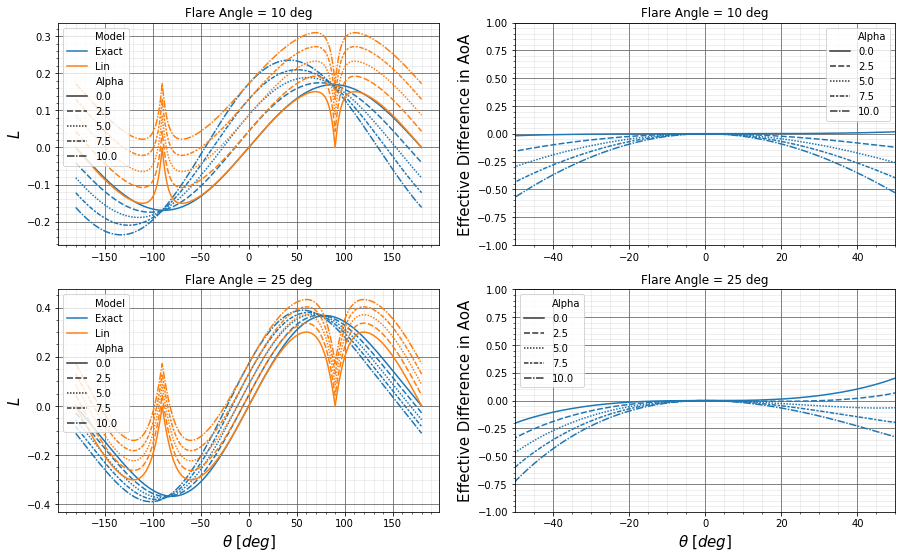

In [159]:
LinModelData = GetFwtAoAFromModel(TestConditions,linModel,'Lin')

Data = ModelData.append(LinModelData,sort=False)
DeltaData = ModelData.copy()
DeltaData['DeltaAlpha_h'] = (DeltaData['DeltaAlpha_h'] - LinModelData['DeltaAlpha_h'])

m1_lift = np.round(DeltaData['DeltaLift'],8)
m2_lift = np.round(LinModelData['DeltaLift'],8)
DeltaData['DeltaLift'] = np.rad2deg((m1_lift - m2_lift)/(2*np.pi))

#DeltaData['DeltaLift'] = (DeltaData['Lift'] - LinModelData['Lift'])/np.pi*180
#DeltaData['DeltaLift'] = (DeltaData['Theta']!=0)*DeltaData['DeltaLift']
#remove 

lams = [10,25]
# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(len(lams),2,figsize=(15,9))
for i in range(0,len(lams)):
    dat = Data[Data['Lambda']==lams[i]]
    sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[i][0],hue='Model')
    #axes[0][0].set(ylim=(-10,10),xlim=(-50,50))
    sns.lineplot(data = DeltaData[DeltaData['Lambda']==lams[i]],x='Theta',y='DeltaLift',style='Alpha',ax=axes[i][1])

    axes[i][0].set_ylabel(r'$L$',fontsize=15)
    axes[i][1].set_ylabel(r'Effective Difference in AoA',fontsize=15)
    #axes[0].set(xlim=(-30,30),ylim=(-10,10))
    axes[i][1].set(xlim=(-50,50),ylim=(-1,1))

    for j in [0,1]:
        axes[i][j].grid(b=True, which='major', color='#666666', linestyle='-')
        if i == len(lams)-1:
            axes[i][j].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
        else:
            axes[i][j].set_xlabel(r'',fontsize=15)
        #Show the minor grid lines with very faint and almost transparent grey lines
        axes[i][j].minorticks_on()
        axes[i][j].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        axes[i][j].set_title(f'Flare Angle = {lams[i]} deg')
    
imageFolder = r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop' '\\'
plt.savefig(imageFolder +  r'LinModelCompare.png',transparent=True,bbox_inches='tight')

Large differences between the models, even at lowish Theta (<20 degrees)

## 'Compare to Non-linear Aeroelastic Behaviuor of Hinged wing-tips'

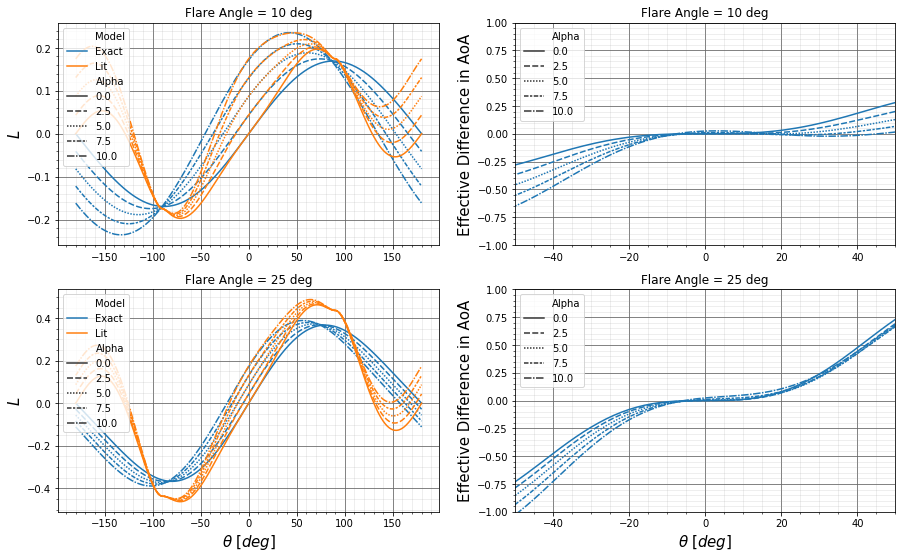

In [131]:
# create forces
LitModelData = TestConditions.copy()

_alpha = np.deg2rad(ModelData['Alpha'])
_beta = np.deg2rad(ModelData['Beta'])
_Lambda = np.deg2rad(ModelData['Lambda'])
_theta = np.deg2rad(ModelData['Theta'])

LitModelData['Lift'] = alp*np.cos(_theta)**2 # lift due to root AoA
LitModelData['Lift'] = LitModelData['Lift'] + np.arctan(np.sin(_Lambda)*np.tan(_theta))*np.cos(_theta)**2 # lift due to flare-twist coupling
LitModelData['Lift'] = LitModelData['Lift'] + _Lambda * np.sin(_theta)**3 # side force contibution
LitModelData['Model'] = 'Lit'
Data = ModelData.append(LitModelData,sort=False)
DeltaData = ModelData.copy()

n = 1
ex_lift = np.round(ModelData[ModelData['Model']=='Exact']['Lift'],5)
lit_lift = np.round(LitModelData['Lift'],5)

DeltaData['DeltaLift'] = np.rad2deg((lit_lift - ex_lift)/(2*np.pi))
#DeltaData['DeltaLift'] = (ex_lift - lit_lift)/(np.abs(ex_lift))*100#(1+n/ex_lift)*100

lams = [10,25]
# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(len(lams),2,figsize=(15,9))
for i in range(0,len(lams)):
    dat = Data[Data['Lambda']==lams[i]]
    sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[i][0],hue='Model')
    #axes[0][0].set(ylim=(-10,10),xlim=(-50,50))
    sns.lineplot(data = DeltaData[DeltaData['Lambda']==lams[i]],x='Theta',y='DeltaLift',style='Alpha',ax=axes[i][1])

    axes[i][0].set_ylabel(r'$L$',fontsize=15)
    axes[i][1].set_ylabel(r'Effective Difference in AoA',fontsize=15)
    #axes[0].set(xlim=(-30,30),ylim=(-10,10))
    axes[i][1].set(xlim=(-50,50),ylim=(-1,1))

    for j in [0,1]:
        axes[i][j].grid(b=True, which='major', color='#666666', linestyle='-')
        if i == len(lams)-1:
            axes[i][j].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
        else:
            axes[i][j].set_xlabel(r'',fontsize=15)
        #Show the minor grid lines with very faint and almost transparent grey lines
        axes[i][j].minorticks_on()
        axes[i][j].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        axes[i][j].set_title(f'Flare Angle = {lams[i]} deg')
    
imageFolder = r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop' '\\'
plt.savefig(imageFolder +  r'LinModelCompare.png',transparent=True,bbox_inches='tight')

## can I do Better?

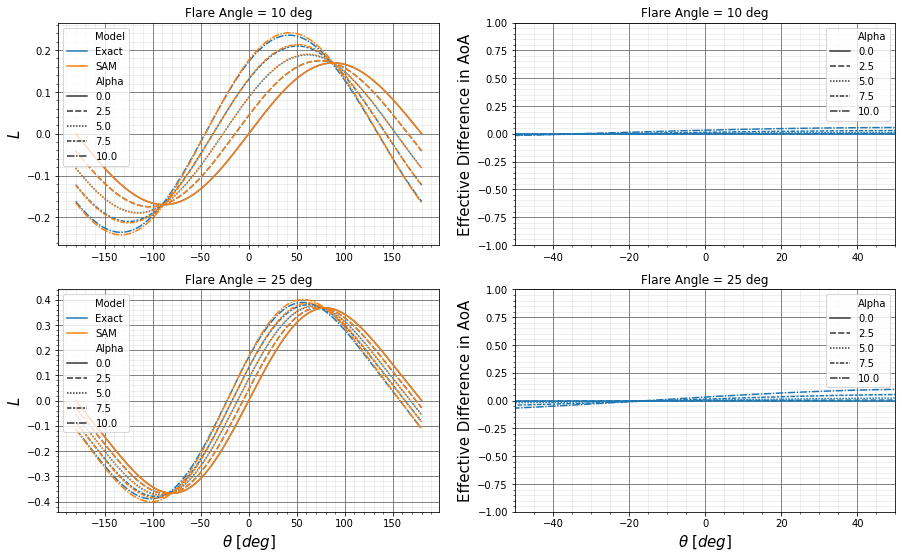

In [134]:
# create forces
# sweep = 0
# small angles AoA
SAM_Model = Vh.subs({sym.sin(alpha):alpha,sym.cos(alpha):1,beta:0})
SmallAnglesModel = sym.lambdify((alpha,beta,Lambda,theta,u),SAM_Model)   

# get data
LinModelData = GetFwtAoAFromModel(TestConditions,SmallAnglesModel,'SAM')
                                
                                
Data = ModelData.append(LinModelData,sort=False)
DeltaData = ModelData.copy()
DeltaData['DeltaAlpha_h'] = (DeltaData['DeltaAlpha_h'] - LinModelData['DeltaAlpha_h'])

m1_lift = np.round(DeltaData['DeltaLift'],8)
m2_lift = np.round(LinModelData['DeltaLift'],8)
DeltaData['DeltaLift'] = np.rad2deg((m2_lift - m1_lift)/(2*np.pi))

#DeltaData['DeltaLift'] = (DeltaData['Lift'] - LinModelData['Lift'])/np.pi*180
#DeltaData['DeltaLift'] = (DeltaData['Theta']!=0)*DeltaData['DeltaLift']
#remove 

lams = [10,25]
# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(len(lams),2,figsize=(15,9))
for i in range(0,len(lams)):
    dat = Data[Data['Lambda']==lams[i]]
    sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[i][0],hue='Model')
    #axes[0][0].set(ylim=(-10,10),xlim=(-50,50))
    sns.lineplot(data = DeltaData[DeltaData['Lambda']==lams[i]],x='Theta',y='DeltaLift',style='Alpha',ax=axes[i][1])

    axes[i][0].set_ylabel(r'$L$',fontsize=15)
    axes[i][1].set_ylabel(r'Effective Difference in AoA',fontsize=15)
    #axes[0].set(xlim=(-30,30),ylim=(-10,10))
    axes[i][1].set(xlim=(-50,50),ylim=(-1,1))

    for j in [0,1]:
        axes[i][j].grid(b=True, which='major', color='#666666', linestyle='-')
        if i == len(lams)-1:
            axes[i][j].set_xlabel(r'$\theta\;[deg]$',fontsize=15)
        else:
            axes[i][j].set_xlabel(r'',fontsize=15)
        #Show the minor grid lines with very faint and almost transparent grey lines
        axes[i][j].minorticks_on()
        axes[i][j].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
        axes[i][j].set_title(f'Flare Angle = {lams[i]} deg')
    
imageFolder = r'C:\Users\qe19391\OneDrive - University of Bristol\Desktop' '\\'
plt.savefig(imageFolder +  r'LinModelCompare.png',transparent=True,bbox_inches='tight')

In [138]:
SAM_Model = Vh.subs({beta:0})
SAM_Model

Matrix([
[      u*(sin(Lambda)**2*cos(alpha)*cos(theta) - sin(Lambda)**2*cos(alpha) - sin(Lambda)*sin(alpha)*sin(theta) + cos(alpha))],
[u*(-sin(Lambda)*cos(Lambda)*cos(alpha)*cos(theta) + sin(Lambda)*cos(Lambda)*cos(alpha) + sin(alpha)*sin(theta)*cos(Lambda))],
[                                                              u*(sin(Lambda)*sin(theta)*cos(alpha) + sin(alpha)*cos(theta))]])

In [136]:
SAM_Model[2]/SAM_Model[0]

(alpha*cos(theta) + sin(Lambda)*sin(theta))/(-alpha*sin(Lambda)*sin(theta) + sin(Lambda)**2*cos(theta) - sin(Lambda)**2 + 1)

In [ ]:
SAM_Model[2]**2+SAM_Model[0]**2

## Linearise the exact equation w.r.t. $\alpha$

As AoA of r will rarely +/- 10 can linearise this part of the equation

also for now we are ignoring Beta

In [22]:
Vh_lin = Vh#.subs({sym.sin(alpha):alpha,sym.cos(alpha):1,beta:0})

#Looking at alpha_h
sym.Eq(sym.tan(alpha_h),Vh_lin[2]/Vh_lin[0])
VLinModel = sym.lambdify((alpha,beta,Lambda,theta,u),Vh)

Matrix([
[           u*(-sin(Lambda)*sin(alpha)*sin(theta) + sin(Lambda)*sin(Lambda + beta)*cos(alpha)*cos(theta) - sin(Lambda)*sin(Lambda + beta)*cos(alpha) + cos(alpha)*cos(beta))],
[u*(-sin(Lambda)*cos(alpha)*cos(theta)*cos(Lambda + beta) + sin(Lambda)*cos(alpha)*cos(Lambda + beta) + sin(alpha)*sin(theta)*cos(Lambda) - sin(beta)*cos(alpha)*cos(theta))],
[                                                                                                       u*(sin(alpha)*cos(theta) + sin(theta)*sin(Lambda + beta)*cos(alpha))]])

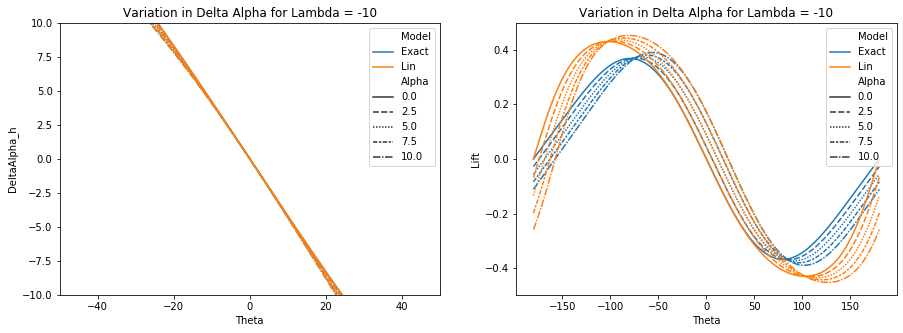

In [23]:
LinModelData = GetFwtAoAFromModel(TestConditions,VLinModel,'Lin')
LinModelData['Lift'] = np.deg2rad(LinModelData['Alpha_h'])*np.cos(np.deg2rad(ModelData['Alpha_h']))
Data = ModelData.append(LinModelData,sort=False)


# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(1,2,figsize=(15,5))
dat = Data[Data['Lambda']==-25]
sns.lineplot(data = dat,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0],hue='Model')
axes[0].set(title='Variation in Delta Alpha for Lambda = -10')
axes[0].set(ylim=(-10,10),xlim=(-50,50))

sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[1],hue='Model')
axes[1].set(title='Variation in Delta Alpha for Lambda = -10')


Vh

How about if we approach it from a differnt angle...

,Alpha,Theta,Lambda,Beta,v1,v2,v3,Alpha_h,DeltaAlpha_h,Beta_h,DeltaBeta_h,u_h,Lift,ZeroLift,DeltaLift,Model
540,0.0,-90.0,-25.0,0,0.821394,-3.830222e-01,0.422618,27.226435,27.226435,-2.500000e+01,-2.500000e+01,0.923739,0.360553,0.000000,0.360553,Exact
2706,2.5,-90.0,-25.0,0,0.802178,-4.221903e-01,0.422216,27.759505,25.259505,-2.775806e+01,-2.775806e+01,0.906507,0.352315,0.043592,0.308723,Exact
4872,5.0,-90.0,-25.0,0,0.781435,-4.605546e-01,0.421010,28.314261,23.314261,-3.051385e+01,-3.051385e+01,0.887631,0.342774,0.086934,0.255840,Exact
7038,7.5,-90.0,-25.0,0,0.759204,-4.980423e-01,0.419003,28.894194,21.394194,-3.326511e+01,-3.326511e+01,0.867153,0.332003,0.129780,0.202223,Exact
9204,10.0,-90.0,-25.0,0,0.735528,-5.345819e-01,0.416198,29.503302,19.503302,-3.600966e+01,-3.600966e+01,0.845117,0.320084,0.171881,0.148203,Exact
540,0.0,-90.0,-25.0,0,0.834817,0.000000e+00,0.352809,22.909807,22.909807,0.000000e+00,0.000000e+00,0.906308,0.302528,0.000000,0.302528,Lin
2706,2.5,-90.0,-25.0,0,0.834817,4.361939e-21,0.352809,22.909807,20.409807,2.993718e-19,2.993718e-19,0.906308,0.302528,0.043592,0.258936,Lin
4872,5.0,-90.0,-25.0,0,0.834817,8.715574e-21,0.352809,22.909807,17.909807,5.981737e-19,5.981737e-19,0.906308,0.302528,0.086934,0.215594,Lin
7038,7.5,-90.0,-25.0,0,0.834817,1.305262e-20,0.352809,22.909807,15.409807,8.958369e-19,8.958369e-19,0.906308,0.302528,0.129780,0.172748,Lin
9204,10.0,-90.0,-25.0,0,0.834817,1.736482e-20,0.352809,22.909807,12.909807,1.191795e-18,1.191795e-18,0.906308,0.302528,0.171881,0.130647,Lin


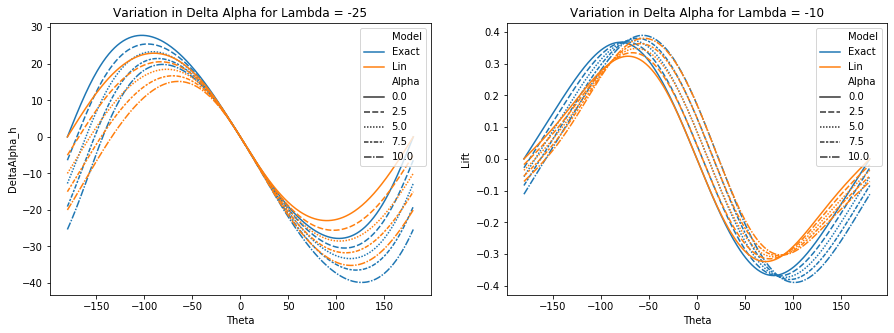

In [17]:
linAlpha = sym.atan(sym.sin(theta)*sym.sin(Lambda)) + sym.cos(theta)*alpha
V = sym.ones(3,1)
sweep = (sym.cos(theta)-1)*Lambda
V[0] = sym.cos(linAlpha)*u*sym.cos(sweep)
V[1] = u*sym.sin(alpha)*1e-19
V[2] = sym.sin(linAlpha)*u*sym.cos(sweep)
linModel = sym.lambdify((alpha,beta,Lambda,theta,u),V)

LinModelData = GetFwtAoAFromModel(TestConditions,linModel,'Lin')
#LinModelData['DeltaAlpha_h'] = LinModelData['Alpha_h']

Data = ModelData.append(LinModelData,sort=False)


# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(1,2,figsize=(15,5))
dat = Data[Data['Lambda']==-25]
sns.lineplot(data = dat,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0],hue='Model')
axes[0].set(title='Variation in Delta Alpha for Lambda = -25')
# axes[0].set(ylim=(-10,10),xlim=(-50,50))

sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[1],hue='Model')
axes[1].set(title='Variation in Delta Alpha for Lambda = -10')
sweep
dat[dat['Theta']==-90]

Thats better than a poke in the eye with a sharp stick!



How does the model used in the paper compare?

[Text(0.5, 1.0, 'Variation in Delta Alpha for Lambda = -10')]

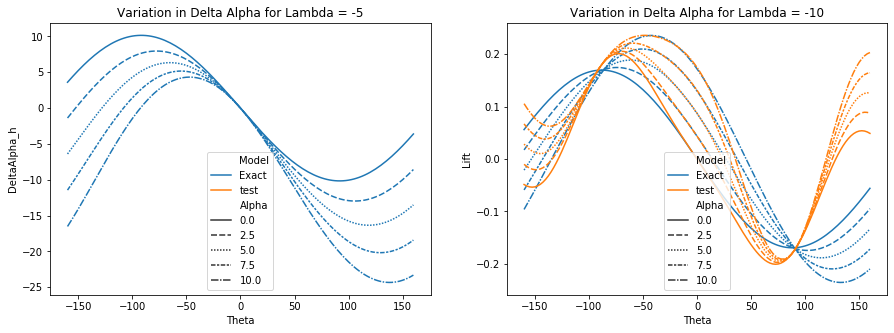

In [172]:
Data = TestConditions.copy()
L = np.deg2rad(Data['Lambda'])
t= np.deg2rad(Data['Theta'])
a = np.deg2rad(Data['Alpha'])
Data['L'] = np.arctan(np.sin(L)*np.sin(t))*np.cos(t)
Data['S'] = L*np.sin(t)**3 + a*np.cos(t)**2
Data['Lift'] = Data['L'] + Data['S']
Data['Model'] = 'test'
Data = ModelData.append(Data,sort=False)


# compare to the exact
# plot the interesting things
fig, axes = plt.subplots(1,2,figsize=(15,5))
dat = Data[Data['Lambda']==-10]
sns.lineplot(data = dat,x='Theta',y='DeltaAlpha_h',style='Alpha',ax=axes[0],hue='Model')
axes[0].set(title='Variation in Delta Alpha for Lambda = -5')
# axes[0].set(ylim=(-10,10),xlim=(-50,50))

sns.lineplot(data = dat,x='Theta',y='Lift',style='Alpha',ax=axes[1],hue='Model')
axes[1].set(title='Variation in Delta Alpha for Lambda = -10')

#axes[1].set(xlim=(-50,50))



my point......

In [176]:
Vh.sub({theta:0})

AttributeError: ImmutableDenseMatrix has no attribute sub.